# One-dimensional bar subjected to tension/compresion (Hello world example)

## General formulation of the problem
Let us consider a beam with rectangular cross-section that is constant along the centerline of the beam, which coincides with the $x$-axis.
The beam is loaded with the volumetric force density $\mathbf{f}$ acting only in the direction of the $x$-axis. This results in extension or compression of the beam. The beam is fixed at the boundary $\Gamma_D$.

In [1]:
%load_ext tikzmagic

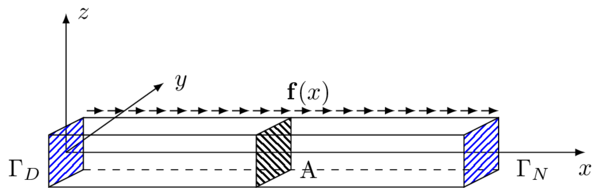

In [59]:
%%tikz -l patterns -s 600,320
\input{formulation.tikz};

### Governing equations
The problem for displacement $\mathbf{u}:\Omega \to \mathbb{R}^3$ of isotropic solid at small strains reads
\begin{align*}
	\text{div} \tau &= \mathbf{f} && \text{in } \Omega, \\
	\tau \mathbf{n} &= \mathbf{g} && \text{on } \Gamma_N, \\
	\mathbf{u} &= \mathbf{u}_D && \text{on } \Gamma_D,
\end{align*}
where
\begin{align*}
	\tau = \lambda (\text{tr} \varepsilon(\mathbf{u})) \mathbb{I} + 2\mu \varepsilon(\mathbf{u})
\end{align*}
is the Cauchy stress tensor (with $\varepsilon(\mathbf{u})$ being the symmetric gradient of $\mathbf{u}$,
and $\lambda$ with $\mu$ the Lamé parameters),
$\mathbf{f}$ is the volume force density,
$\mathbf{g}$ is the normal traction on the Neumann part of the boundary of $\Omega$,
and $\mathbf{u}_D$ is the prescribed displacement at the Dirichlet part of $\partial \Omega$.
When reducing the problem for an axial dilatation and a radial compression we suppose
\begin{align*}
	\mathbf{u}
	=
	\begin{pmatrix}
		u_x (x) \\
		u_y(y,z) \\
		u_z(y,z)
	\end{pmatrix},
	\qquad
	\mathbf{f}
	=
	\begin{pmatrix}
		f_x(x) \\
		f_y(y,z) \\
		f_z(y,z)
	\end{pmatrix},
\end{align*}
and that $\mathbf{g}$ is zero on the walls and points in the axial direction at both ends.
The system then partially separates; the equation for the component $u_x$ becomes independent.
Its solutions than enters the equations for $u_y$ and $u_z$ via the traction on the boundary
(here the Poisson's ratio comes into play); however, we are interested in finding solely $u_x$.
When integrate its equation over the cross-section with an area $A$, we obtain
\begin{align*}
	A (\lambda + 2\mu)(u_x)'' = A f_x.
\end{align*}
Since we want to describe the material properties rather with Young modulus $E$ and Poisson's ration $\nu$,
we substitute
\begin{align*}
	\lambda + 2\mu = \frac{E(1-\nu)}{(1+\nu)(1-2\nu)}.
\end{align*}
When supposing $\nu = 0$,
we end up with the reduced problem for $u:=u_x$
\begin{align*}
	A E u'' &= f \text{ in } (0,L), \\
	u(0) &= 0, \\
	AEu'(L) &= g,
\end{align*}
where $f(x) = Af_x(x)$ and $g = g_x(L)$.
Weak formulation is
\begin{align*}
	u \in V: \int_0^L A E u'(x) \varphi'(x) + f(x)\varphi(x)\, \text{d} x = g \varphi(L), \forall \varphi \in V\,,
\end{align*}
where $V = \{ v \in H^1(0,L); v(0) = 0\}$.
Note that $H^1(0,L) \subset AC[0,L]$, thus $\varphi$ is defined pointwise.

## Implementation

First of all, we must import fenics library to python interface. Moreover we import *pyplot* library which is used for graphs rendering.

In [6]:
import fenics as fe
import matplotlib.pyplot as plt
# komentovat jednotlive kroky v pythonu nebo ne?

### Problem parameters
Let us set the material parameters of the problem. Following is the table that contains Young modulus and Poisson's ratio for some common materials.

| Material | Young modulus $E\ [GPa]$ | Poisson's ratio $\nu\ [-]$ |
| -------- |:-------------:| -----:|
| Rubber   | $0.01 - 0.1$  | $0.4999$ |
| Cork     | $0.02 - 0.03$    |   $0$ |
| Concrete | $30$      |    $0.1 - 0.2$ |
| Steel    | $200$      |    $0.27 - 0.30$ |

In [7]:
# --------------------
# Parameters
# --------------------
E = 10.0  # Young's modulus
A = 0.5  # Cross-section area of bar
l = 2.0  # Length of bar
n = 20  # Number of elements
f = 3.0  # Load intensity

### Generating geometry of the problem

Now, we define geometry of problem. There is always possibility to use external mesh defined in *.xml* file. In this case we use the predefined mesh provided directly by fenics. By fenics object ``IntervalMesh(n, x_1, x_2)`` we can create equidistantly discretized 1D mesh with $n$ elements and with two end point $x_1$ and $x_2$.

>možná bych přidal komentář, že je možné v pythonu přistupovat k help formulářům jednotlivých funkcí, lze se tam dočíst alespoň jaké argumenty funkce přijímá

In [14]:
help(fe.IntervalMesh)

Help on class IntervalMesh in module dolfin.cpp.generation:

class IntervalMesh(dolfin.cpp.mesh.Mesh)
 |  DOLFIN Mesh object
 |  
 |  Method resolution order:
 |      IntervalMesh
 |      dolfin.cpp.mesh.Mesh
 |      dolfin.cpp.common.Variable
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: dolfin.cpp.generation.IntervalMesh, arg0: int, arg1: float, arg2: float) -> None
 |      
 |      2. __init__(self: dolfin.cpp.generation.IntervalMesh, arg0: MPICommWrapper, arg1: int, arg2: float, arg3: float) -> None
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from dolfin.cpp.mesh.Mesh:
 |  
 |  bounding_box_tree(...)
 |      bounding_box_tree

In [10]:
# --------------------
# Geometry
# --------------------
mesh = fe.IntervalMesh(n, 0.0, l)

Mesh can be directly plotted to check it.

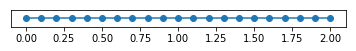

In [4]:
fe.plot(mesh)
plt.show()

### Function spaces definition
Now we can create function space where solution and test function live by creating object *FunctionSpace* with three arguments. First is discretized domain saved in *mesh* variable. Second is type of base functions and order of these functions is third argument. We present several types of element later. In this example we use the most common choice which is *Lagrange/Continous Galerkin* element (it is why keyword 'CG' is used) of order 1. Last two lines create test and trial function at this space.

>odkaz na definice prostorů ze slabé formulace?

In [5]:
# --------------------
# Function spaces
# --------------------
V = fe.FunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

### Boundary condtions
Following function serves for definition of $\Gamma_u$ space. keyword *on_boundary* returns true for all point on boundary and it is possible add another conditions. Presented example defines only left point of bar.

>ekvivalentní definice pomocí MeshFunction, která je delší ale pro člověka bez znalosti objektového programování možná trochu lépe srozumitelná, mozna ale ne

In [ ]:
boundary = fe.MeshFunction("size_t", mesh, mesh.topology().dim()-1,0)
for f in fe.facets(mesh):
    if near(f.midpoint(), 0.0):
        boundary[f] = 1 # left
    elif near(f.midpoint(), 1.0):
        boundary[f] = 2 # right

In [8]:
# --------------------
# Functions and classes
# --------------------
def left(x, on_boundary):
    return fe.near(x[0], 0.0) and on_boundary

 Dirichlet boundary conditions are defined by object *DirichletBC* with three arguments: Function space, prescribed value and corresponding $\Gamma_{u}$.
 
 >možná přidat okénko s odkazem na Neumannovu okrajovou podmínku, která se projeví ve slabé formulaci + její fyzikální význam v tomto případě
 
 #### Other types of boundary conditions*
 Neumann boudnary condtion


In [6]:
# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, 0.0, left)

Now we can define weak form of task. FEniCS wants two information from us. Firstly, we must define symbolically integrand and secondly, we must also define integration domain. The latter is define throught object *fe.dx*. Not to be confused with *.dx(0)* which stands for first derivative.

>tady bych zvážil jestli to rovnou nepsat v složkově invariantním tvaru, když jej budeme používat i v ostatních slabých formulacích, možná ale naopak bude lepší ukázát různé způsoby formulace

In [9]:
# --------------------
# Weak form
# --------------------
a = E*A*u_tr.dx(0)*u_test.dx(0)*fe.dx
l = f*u_test*fe.dx

Finaly, task is solved by calling *.solve()* function with three parameters: Solved linear variational equation, function where solution will be stored and Dirichlet boundary conditions. Before we call *.solve()* procedure, we must create some function by object *Function*. It creates zero function on space $V$ and by calling *.solve()*, this function is filled by FEM solution.

>vnímám jako výhodnější si nadefinovat problem pomocí LinearVariationalProblem a následně jeho solver, tady je to jedno, ale u evolučních úloh je taková formulace efektivnější a navíc ušetří psaní několika řádků kódu

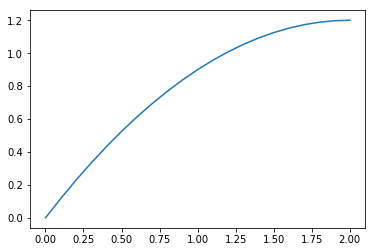

In [11]:
# --------------------
# Solver
# --------------------
u = fe.Function(V)
fe.solve(a == l, u, bc)
# F = a-l
# problem = fe.LinearVariationalProblem(fe.lhs(F),fe.rhs(F),u,bc)
# solver = fe.LinearVariationalSolver(problem)

# --------------------
# Post-process
# --------------------
fe.plot(u)
plt.show()

>Pokud to půjde, bylo by fajn popsat osy a přidat nějakou interpretaci obrázku, jestli jsme dostali to, co bychom chtěli

## Code

In [ ]:
import fenics as fe
import matplotlib.pyplot as plt

# --------------------
# Parameters
# --------------------
E = 10.0  # Young's modulus
A = 0.5  # Cross-section area of bar
l = 2.0  # Length of bar
n = 20  # Number of elements
f = 3.0  # Load intensity

# --------------------
# Geometry
# --------------------
mesh = fe.IntervalMesh(n, 0.0, l)

fe.plot(mesh)
plt.show()

# --------------------
# Function spaces
# --------------------
V = fe.FunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

# --------------------
# Functions and classes
# --------------------
def left(x, on_boundary):
    return fe.near(x[0], 0.0) and on_boundary

# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, 0.0, left)

# --------------------
# Weak form
# --------------------
a = E*A*u_tr.dx(0)*u_test.dx(0)*fe.dx
l = f*u_test*fe.dx

# --------------------
# Solver
# --------------------
u = fe.Function(V)
fe.solve(a == l, u, bc)

# --------------------
# Post-process
# --------------------
fe.plot(u)
plt.show()